In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터 전처리

In [2]:
import numpy as np 
import imutils 
import dlib 
import cv2

from imutils import face_utils 
from google.colab.patches import cv2_imshow

In [25]:
def mask_point_detection(image, detector, predictor): 
  """
  OpenCV ,dlib library를  이용해 이미지의 마스크영역 검출
  Args:
    image : 원본 이미지
    detector, predictor : dlib class, file
  Return:
    point : 마스크영역
  """
  image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)
  for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect) 
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (shape[2][0]-30, shape[2][1]-30), (shape[16][0]+30, shape[9][1]+30), (0, 255, 0), 1)
    [x_left, y_left, x_right, y_right] =  shape[2][0]-25, shape[2][1]-25, shape[16][0]+25, shape[9][1]+25
    point = [x_left, y_left, x_right, y_right]  # box point
    for (x, y) in shape: 
      cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    # cv2_imshow(image)
  return point

# example
# image = '/content/drive/MyDrive/maskGAN/data/without_mask/000012.jpg'
# image = cv2.imread(image)
# detector = dlib.get_frontal_face_detector() 
# predictor = dlib.shape_predictor('/content/drive/MyDrive/maskGAN/shape_predictor_68_face_landmarks.dat')
# mask_point_detection(image, detector, predictor)

In [24]:
def image_processing(image, mask_image, point, maskname):
    """
    원본 이미지에 마스크를 씌운 합성이미지, Binary이미지를 PATH에 저장
    Args:
      image : 원본 이미지
      mask_image : 마스크 객체 이미지
      point : 얼굴인식 point
      maskname : 이미지 이름 (검은색, 파란색, 흰색)
    """

    save_image_dir = '/content/drive/MyDrive/maskGAN/data/train/image1'
    save_binary_image_dir = '/content/drive/MyDrive/maskGAN/data/binary_image1'
    x_left, y_left, x_right, y_right = point[0], point[1], point[2], point[3]

    if maskname == 'black.jpeg':
        image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        original_image = image.copy()
        mask_image = cv2.resize(mask_image, dsize=(x_right-x_left, y_right-y_left), interpolation=cv2.INTER_AREA)

        gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY) #마스크이미지의 색상을 그레이로 변경
        ret, mask = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY) #배경은 흰색으로, 그림을 검정색으로 변경
        mask_inv = cv2.bitwise_not(mask)
        # cv2_imshow(mask) 
        # cv2_imshow(mask_inv) 

        crop = image[y_left:y_right, x_left:x_right]    
        # cv2_imshow(crop)          
        mask_face_crop = cv2.copyTo(mask_image, mask_inv, crop)   # black mask > mask_inv대신
        image[y_left:y_right, x_left:x_right] = mask_face_crop 

        binary_image= np.zeros([image.shape[0], image.shape[1]])
        binary_image[y_left:y_right, x_left:x_right] = mask_inv

    elif maskname == 'blue.png':
        image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        original_image = image.copy()
        mask_image = cv2.resize(mask_image, dsize=(x_right-x_left, y_right-y_left), interpolation=cv2.INTER_AREA)

        gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY) 
        ret, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY) 
        mask_inv = cv2.bitwise_not(mask)

        #cv2_imshow(mask) 
        #cv2_imshow(mask_inv) 

        crop = image[y_left:y_right, x_left:x_right]
        mask_face_crop = cv2.copyTo(mask_image, mask_inv, crop)   # blue mask > mask_inv
        image[y_left:y_right, x_left:x_right] = mask_face_crop 

        binary_image= np.zeros([image.shape[0], image.shape[1]])
        binary_image[y_left:y_right, x_left:x_right] = mask_inv

    else:
        image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        original_image = image.copy()
        mask_image = cv2.resize(mask_image, dsize=(x_right-x_left, y_right-y_left), interpolation=cv2.INTER_AREA)

        gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY) 
        ret, mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY) 
        mask_inv = cv2.bitwise_not(mask)

        # cv2_imshow(mask) 
        # cv2_imshow(mask_inv)

        crop = image[y_left:y_right, x_left:x_right]
        mask_face_crop = cv2.copyTo(mask_image, mask, crop)   # white mask >  mask
        image[y_left:y_right, x_left:x_right] = mask_face_crop 

        binary_image= np.zeros([image.shape[0], image.shape[1]])
        binary_image[y_left:y_right, x_left:x_right] = mask

    
    merge_image = np.concatenate([image, original_image],axis = 1)    # 원본, 합성이미지 concat
    # cv2_imshow(mask_image)
    # cv2_imshow(mask_inv)     
    # cv2_imshow(mask_face_crop)
    # cv2_imshow(merge_image) 
    # cv2_imshow(binary_image)

    #  image save
    cv2.imwrite(save_image_dir+'/with_mask_00{num}.jpg'.format(num=i+1),merge_image)
    cv2.imwrite(save_binary_image_dir+'/binary_00{num}.jpg'.format(num=i+1), binary_image)

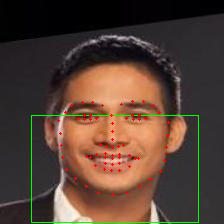

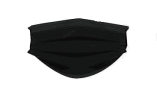

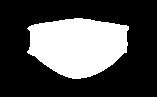

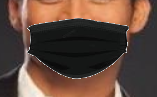

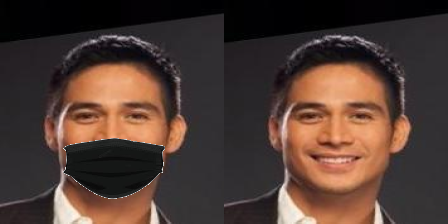

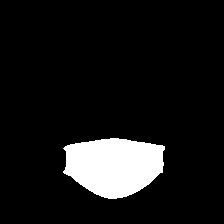

In [ ]:
image = '/content/drive/MyDrive/maskGAN/data/without_mask/000012.jpg'
mask_image = '/content/drive/MyDrive/maskGAN/data/mask/black.jpeg'
image = cv2.imread(image) 
mask_image = cv2.imread(mask_image)
point = mask_point_detection(image, detector, predictor)
image_processing(image, mask_image, point, 'black.jpeg')

In [ ]:
import os
import random

# face, mask image PATH
face_path = '/content/drive/MyDrive/maskGAN/data/without_mask1'
mask_path = '/content/drive/MyDrive/maskGAN/data/mask'

face_file_list = os.listdir(face_path)
mask_file_list = os.listdir(mask_path)
face_file_list = sorted(face_file_list)
mask_file_list = sorted(mask_file_list)

In [ ]:
print(len(face_file_list))
face_file_list = face_file_list[1500:]

3000


In [ ]:
# 마스크 합성이미지 생성
random.seed(42)

import time

detector = dlib.get_frontal_face_detector() 
predictor = dlib.shape_predictor('/content/drive/MyDrive/maskGAN/shape_predictor_68_face_landmarks.dat')

fail_image=[]

for i, imagename in enumerate(face_file_list) :
    i = i + 11500
    image = cv2.imread(face_path+"/"+imagename) 
    maskname = random.choice(mask_file_list)       # mask image rondom choice
    mask_image = cv2.imread(mask_path+'/'+maskname)
    
    try:
        point = mask_point_detection(image, detector, predictor)
        image_processing(image, mask_image, point, maskname)
    except (UnboundLocalError, ValueError):        # 마스크검출 영역이 마스크 사이즈 보다 작은면 pass
        fail_image.append(imagename)
        pass
    time.sleep(0.3)
print(len(fail_image))    
print(fail_image)    

DataSet만들기

In [ ]:
trian1 = '/content/drive/MyDrive/maskGAN/data/train/image'
train2 = '/content/drive/MyDrive/maskGAN/data/binary_image1'
trian1 = os.listdir(trian1)
train2 = os.listdir(train2)
print('데이터 갯수 :', len(trian1) + len(train2))

데이터 갯수 : 6322


In [29]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16740893056242049104
xla_global_id: -1
]


In [30]:
def image_load(image_file):
    """
    image load, 하나의 이미지로 된 real_image, mask_image 분할
    """
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)

    w = tf.shape(image)[1]
    w = w // 2

    real_image = image[:, w:, :]
    mask_image = image[:, :w, :]

    # Convert both images to float32 tensors
    mask_image = tf.cast(mask_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return mask_image, real_image

In [31]:
def binary_load(image_file):
    """
    Binary image load
    """
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)

    input_image = image[:, :, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)

    return input_image

In [32]:
def resize_and_normalize(input_image, real_image, height, width):
  """
  image resize and [-1 ~ 1] normalize
  """
  if real_image is not None:
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

  else:
    input_image = tf.image.resize(input_image, [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    return input_image

In [33]:
def load_image_train(image_file):
  mask_image, real_image = image_load(image_file)
  mask_image, real_image = resize_and_normalize(mask_image, real_image, 256, 256)

  return mask_image, real_image

def load_binary_train(image_file):
  input_image = binary_load(image_file)
  input_image = resize_and_normalize(input_image, None, 256, 256)

  return input_image  

In [ ]:
import os
import natsort
 
BATCH_SIZE = 4
TRAIN_MASK_FACE_PATH = '/content/drive/MyDrive/maskGAN/data/train/image1'
TRAIN_BINARY_PATH = '/content/drive/MyDrive/maskGAN/data/binary_image1'
train_mask_face_file = os.listdir(TRAIN_MASK_FACE_PATH)
train_binary_file = os.listdir(TRAIN_BINARY_PATH)

mask_face_list = [TRAIN_MASK_FACE_PATH+'/'+fileanme for fileanme in natsort.natsorted(train_mask_face_file)]
binary_list = [TRAIN_BINARY_PATH+'/'+fileanme for fileanme in natsort.natsorted(train_binary_file)]

mask_face_train_dataset = tf.data.Dataset.list_files(mask_face_list, shuffle=False)
mask_face_dataset = mask_face_train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
mask_face_dataset = mask_face_dataset.batch(BATCH_SIZE)

binary_train_dataset = tf.data.Dataset.list_files(binary_list, shuffle=False)
binary_dataset = binary_train_dataset.map(load_binary_train, num_parallel_calls=tf.data.AUTOTUNE)
binary_dataset = binary_dataset.batch(BATCH_SIZE)

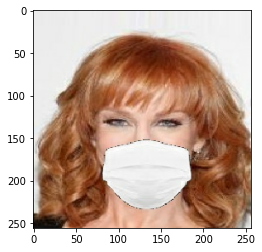

In [ ]:
# 입력 데이터 예시
for i, (mask, real) in enumerate(mask_face_dataset):
  plt.imshow(array_to_img(mask[0]))
  break

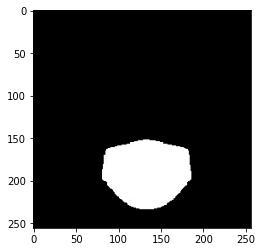

In [ ]:
# 입력 데이터 예시
for i, a in enumerate(binary_dataset):
  plt.imshow(array_to_img(a[0]))
  break

Mask Generator 구축

In [37]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_batchnorm=False, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [38]:
def Mask_Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 3),  # (batch_size, 64, 64, 128)
    downsample(256, 3),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)

  ]

  up_stack = [
    upsample(512, 3, apply_dropout=False),  # (batch_size, 16, 16, 1024)
    upsample(256, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  #x = tf.keras.layers.Flatten()(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

In [39]:
mask_generator = Mask_Generator()

In [ ]:
def generate_images(model, test_input, tar):
  """
  Generate된 이미지 시각화
  Args:
    model : Generate model
  """
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

for example_input, example_target in mask_face_dataset.take(1):
  for example_tar in binary_dataset.take(1):
   generate_images(mask_generator, example_input, example_tar)
   break
  break   

In [ ]:
sparseCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(gen_output, target):
  #gan_loss = sparseCE(target, gen_output)
  # Mean absolute error
  l1_loss = 100 * tf.reduce_mean(tf.abs(target - gen_output))
  # total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return l1_loss

In [ ]:
# @tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = mask_generator(input_image, training=True)
    
    # L1 loss
    gen_loss = generator_loss(gen_output, target)
    
  generator_gradients = gen_tape.gradient(gen_loss,
                                          mask_generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          mask_generator.trainable_variables))

In [ ]:
import time
from IPython import display

def fit(train_ds, test_ds, epoch):

  dataSet = tf.data.Dataset.zip((train_ds, test_ds))  
  for num in range(epoch):
    start = time.time()
    for step, ((mask_input,_),target) in enumerate(dataSet):
      if (step) % 100 == 0:
        display.clear_output(wait=True)
        if step != 0:
          print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')
        start = time.time()
        generate_images(mask_generator, mask_input, target)
        print(f"Step: {step//100}")

      train_step(mask_input, target, step)

      # Training step
      if (step+1) % 10 == 0:
        print('.', end='', flush=True)

      # Save (checkpoint) the model every 800 steps
      if (step + 1) % 800 == 0:
        mask_generator.save("/content/drive/MyDrive/maskGAN/training_checkpoints/mask_model_epoch{epoch}_step{step}.h5".format(epoch=num+1, step=step+1))

In [ ]:
fit(mask_face_dataset, binary_dataset, epoch=2)

In [41]:
mask_generator.load_weights('/content/drive/MyDrive/maskGAN/training_checkpoints/mask_model_epoch4_step800.h5')

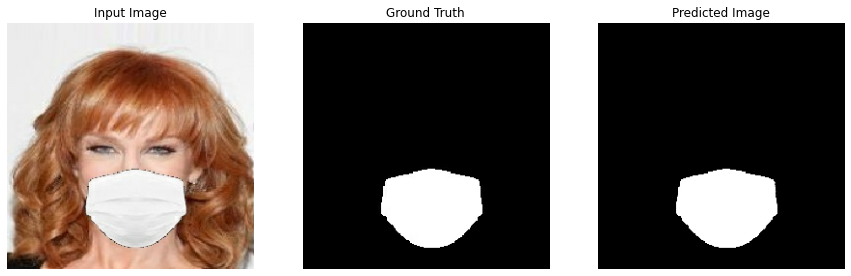

In [ ]:
for example_input, example_target in mask_face_dataset.take(1):
  for example_tar in binary_dataset.take(1):
   generate_images(mask_generator, example_input, example_tar)
   break
  break  

In [42]:
import numpy as np
import cv2
def noise_processing(mask_image, generate_image):
    """
    Mask Generator를 통해 이미지에 원본 이미지를 합성하여 Noise 생성
    Args:
      mask_image : 마스크 쓴 인물 이미지
      generate_image : model를 통해 생성된 이미지
    Return:
      Noiser가 된 인물 이미지
    """
    images = []
    noise = np.random.rand(256, 256, 3)*255.0
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    batch = mask_image.shape[0]

    for i in range(batch):
        image = mask_image[i, :, :, :]
        mask = generate_image[i, :, :, :]
        # mask = cv2.erode(mask, k)             #  mask  Morphology 연산 전처리
        # mask = cv2.dilate(mask, k)

        mask = (mask + 1) * 127.5
        image = (image + 1) * 127.5
        image = image.numpy()
        # _, mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)   #  mask 전처리
        
        # Masking된 RGB채널에 노이즈 생성
        image1 = np.where(mask[:,:,0] == 0, image[:, :, 0], noise[:,:,0])
        image2 = np.where(mask[:,:,1] == 0, image[:, :, 1], noise[:,:,1])
        image3 = np.where(mask[:,:,2] == 0, image[:, :, 2], noise[:,:,2])

        image1 = image1[:, :, np.newaxis]
        image2 = image2[:, :, np.newaxis]
        image3 = image3[:, :, np.newaxis]

        noise_image = np.concatenate([image1, image2], axis=-1)
        noise_image = np.concatenate([noise_image, image3], axis=-1)

        images.append(noise_image[np.newaxis, :, :, :])

    image_input = np.array(images).reshape((batch, 256, 256, 3))
    image_input = tf.convert_to_tensor(image_input, dtype=tf.float32)
    return (image_input / 127.5) - 1

In [ ]:
dataSet = tf.data.Dataset.zip((mask_face_dataset, binary_dataset))

for step, ((a,b), c) in enumerate(dataSet):
  aa = mask_generator(a, training=False)
  image = noise_processing(b, aa)
  break

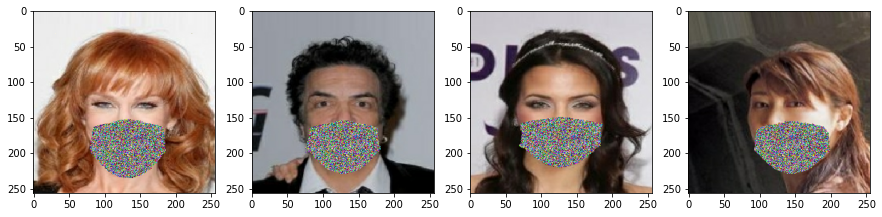

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.imshow(array_to_img(image[0]))
plt.subplot(142)
plt.imshow(array_to_img(image[1]))
plt.subplot(143)
plt.imshow(array_to_img(image[2]))
plt.subplot(144)
plt.imshow(array_to_img(image[3]))

Face Generator구축

In [43]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def face_generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 3),  # (batch_size, 64, 64, 128)
    downsample(256, 3),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 16, 16, 1024)
    upsample(256, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)  

In [44]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [45]:
face_generator = face_generator()
discriminator = Discriminator()

In [ ]:
LAMBDA = 100
face_generator_BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def face_generator_loss(disc_generated_output, gen_output, target):
  gan_loss = face_generator_BCE(tf.ones_like(disc_generated_output), disc_generated_output)
  ssim_loss = tf.image.ssim(target, gen_output, max_val=1.0)
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = ssim_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = face_generator_BCE(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = face_generator_BCE(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss  

In [ ]:
def generate_images2(model, test_input, tar):
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = face_generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, _, _= face_generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          face_generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          face_generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
def fit(train_ds, test_ds, epoch):

  dataSet = tf.data.Dataset.zip((train_ds, test_ds))  
  for num in range(epoch):
    start = time.time()

    for step, ((mask_input, real_input), target) in enumerate(dataSet):
      input_image = mask_generator(mask_input, training=False)
      input_image = noise_processing(real_input, input_image)
      if (step) % 100 == 0:
        display.clear_output(wait=True)

        if step != 0:
          print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

        start = time.time()

        generate_images2(face_generator, input_image, real_input)
        print(f"Step: {step//100}")

      train_step(input_image, real_input, step)

      # Training step
      if (step+1) % 10 == 0:
        print('.', end='', flush=True)


      # Save (checkpoint) the model every 600 steps
      if (step + 1) % 600 == 0:
          face_generator.save("/content/drive/MyDrive/maskGAN/training_checkpoints3/face_gen_epoch{epoch}_step{step}.h5".format(epoch=num+1, step=step+1))
          discriminator.save("/content/drive/MyDrive/maskGAN/training_checkpoints3/face_dis_epoch{epoch}_step{step}.h5".format(epoch=num+1, step=step+1))


Time taken for 100 steps: 50.23 sec



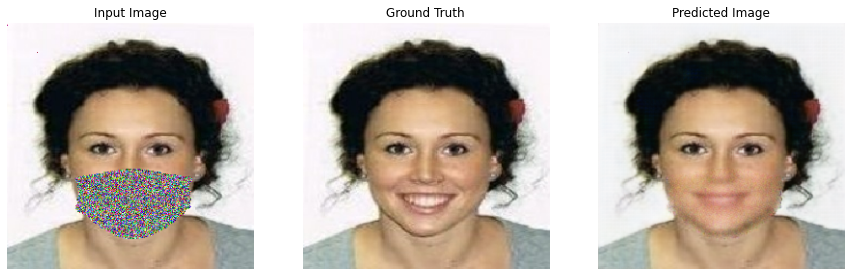

Step: 6
.......

In [ ]:
fit(mask_face_dataset, binary_dataset, epoch=10)

Model Test

In [ ]:
TEST_MASK_FACE_PATH = '/content/drive/MyDrive/maskGAN/data/test/face'
test_files = os.listdir(TEST_MASK_FACE_PATH)
test_files = [TEST_MASK_FACE_PATH+'/'+fileanme for fileanme in natsort.natsorted(test_files)]

test_dataset = tf.data.Dataset.list_files(test_files, shuffle=False)
test_dataset = test_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

GAN Loss + L1 Loss

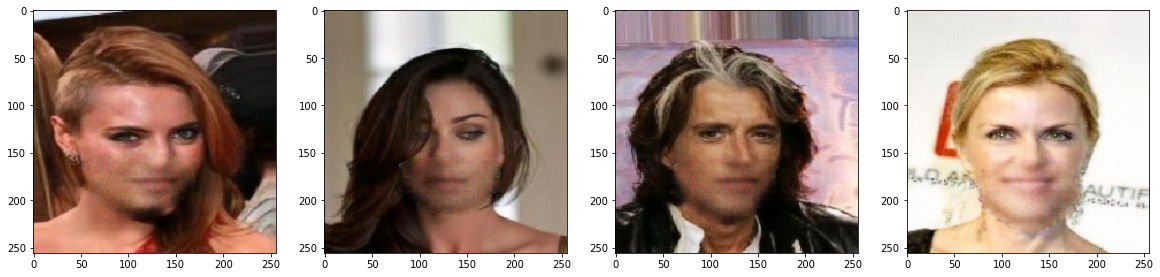

In [ ]:
face_generator.load_weights('/content/drive/MyDrive/maskGAN/training_checkpoints2/face_gen_epoch6_step800.h5')
discriminator.load_weights('/content/drive/MyDrive/maskGAN/training_checkpoints2/face_dis_epoch6_step800.h5')

for step, (mask_face, real_image )in enumerate(test_dataset):
  mask = mask_generator(mask_face, training=False)
  image = noise_processing(mask_face, mask)
  image = face_generator(image, training=False)
  if step == 1:
    break
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(array_to_img(image[0]))
plt.subplot(142)
plt.imshow(array_to_img(image[1]))
plt.subplot(143)
plt.imshow(array_to_img(image[2]))
plt.subplot(144)
plt.imshow(array_to_img(image[3]))    

SSIM Loss + L1 Loss

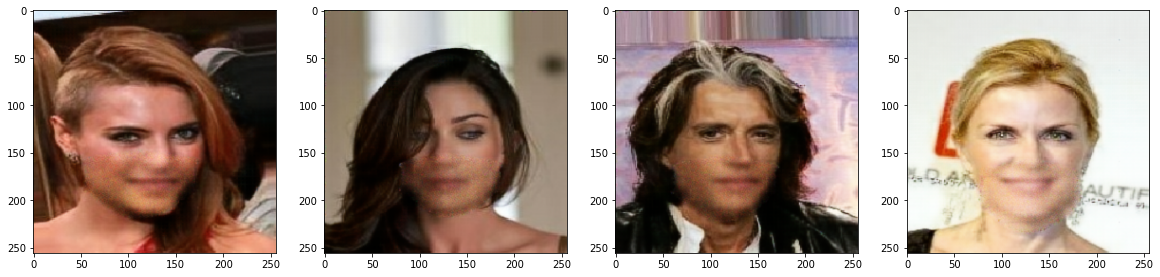

In [ ]:
face_generator.load_weights('/content/drive/MyDrive/maskGAN/training_checkpoints3/face_gen_epoch10_step600.h5')
discriminator.load_weights('/content/drive/MyDrive/maskGAN/training_checkpoints3/face_dis_epoch10_step600.h5')

for step, (mask_face, real_image )in enumerate(test_dataset):
  mask = mask_generator(mask_face, training=False)
  image = noise_processing(mask_face, mask)
  image = face_generator(image, training=False)
  if step == 1:
    break

plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(array_to_img(image[0]))
plt.subplot(142)
plt.imshow(array_to_img(image[1]))
plt.subplot(143)
plt.imshow(array_to_img(image[2]))
plt.subplot(144)
plt.imshow(array_to_img(image[3]))

Real image TEST

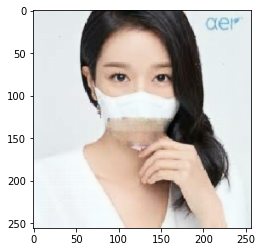

In [ ]:
image = '/content/images2.jpeg'
# image = '/content/image11.JPG'
image = binary_load(image)
image = resize_and_normalize(image, None, 256, 256)
image = image[np.newaxis, :, :, :]
mask = mask_generator(image, training=False)
image = noise_processing(image, mask)
image = face_generator(image, training=False)
plt.imshow(array_to_img(image[0]))

In [52]:
import os
import natsort

TEST_MASK_FACE_PATH = '/content/drive/MyDrive/maskGAN/data/test/mask_face'
test_files = os.listdir(TEST_MASK_FACE_PATH)
test_files = [TEST_MASK_FACE_PATH+'/'+fileanme for fileanme in natsort.natsorted(test_files)]

test_dataset = tf.data.Dataset.list_files(test_files, shuffle=False)
test_dataset = test_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(4)

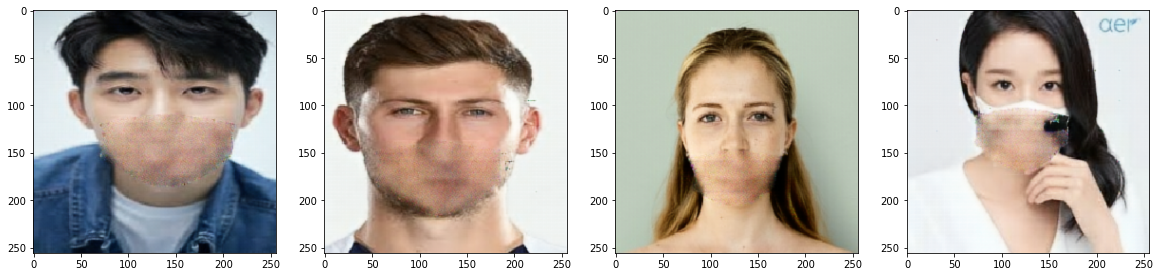

In [54]:
for step, (mask_face, real_image )in enumerate(test_dataset):
  mask = mask_generator(mask_face, training=False)
  image = noise_processing(mask_face, mask)
  image = face_generator(image, training=False)
  if step == 1:
    break
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(array_to_img(image[0]))
plt.subplot(142)
plt.imshow(array_to_img(image[1]))
plt.subplot(143)
plt.imshow(array_to_img(image[2]))
plt.subplot(144)
plt.imshow(array_to_img(image[3]))    